In [2]:
import pandas as pd
from sklearn.cross_validation import train_test_split

data = pd.read_csv('data_banknote_authentication.txt', header=None)
test_data = data.sample(n=472)
test_index = list(test_data.index.values)
train_data = data.drop(test_index)
X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

# (b)i. Passive learning using linear kernal and L1-penalized SVM

In [3]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score
C_range = np.logspace(-1, 4, 6)
avg_test_err = []
test_err_each_svm = [0] * 90
for m in range(50):
#     print('m=%d'%(m+1))
    test_error = 0
    total_select_data=pd.DataFrame()
    train_set = train_data
    for i in range(90):
        select_data = train_set.sample(n=10)
        # If all selected data points are from one class, select another set of 10 data points randomly.
        while all(select_data.iloc[:,-1].value_counts().values) is False:
            select_data = train_set.sample(n=10)

        total_select_data=pd.concat([total_select_data, select_data], axis=0)
        total_select_data.index = range(total_select_data.shape[0])
        select_index = list(select_data.index.values)
        train_set = train_set.drop(select_index)

        X_train = total_select_data.iloc[:,:-1]
        y_train = total_select_data.iloc[:,-1]
        
        for c in C_range:
            cv_acc=0
            max_acc=0
            kf = KFold(n_splits=10)
            count=0
            for train_index, test_index in kf.split(X_train):
                try:
                    svc = LinearSVC(penalty='l1', dual=False, random_state=42).fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
                except:
                    continue
                y_pred_train = svc.predict(X_train.iloc[test_index,:])
                cv_acc += accuracy_score(y_train.iloc[test_index], y_pred_train)
                count=count+1
            if cv_acc/count > max_acc:
                max_acc = cv_acc/count
                best_C = c

        svc = LinearSVC(penalty='l1', dual=False, C=best_C, random_state=42).fit(X_train, y_train)
        y_pred_test = svc.predict(X_test)
        test_err_each_svm[i] += 1-accuracy_score(y_test, y_pred_test)
        test_error += 1-accuracy_score(y_test, y_pred_test)
    avg_test_err.append(test_error/90)

print('The 50 test errors for the 90 SVMs are:',avg_test_err)

The 50 test errors for the 90 SVMs are: [0.019444444444444427, 0.014006591337099783, 0.015301318267419914, 0.011087570621468918, 0.011699623352165702, 0.015913370998116756, 0.015371939736346476, 0.014995291902071543, 0.012758945386064011, 0.014030131826741973, 0.01617231638418077, 0.01414783427495288, 0.014053672316384155, 0.012570621468926532, 0.016784369114877577, 0.015395480225988677, 0.01556026365348397, 0.01344161958568736, 0.014430320150659103, 0.016760828625235376, 0.0116996233521657, 0.014995291902071524, 0.016407721280602583, 0.019279661016949143, 0.012217514124293763, 0.01254708097928434, 0.012429378531073421, 0.010334274952918998, 0.012499999999999978, 0.013983050847457597, 0.01405367231638415, 0.013841807909604497, 0.015772128060263624, 0.014430320150659107, 0.01344161958568737, 0.011581920903954776, 0.013653483992467009, 0.01184086629001881, 0.014642184557438771, 0.011982109227871917, 0.015513182674199601, 0.014406779661016923, 0.013064971751412397, 0.014524482109227849, 0

In [4]:
passive_learning_error = sum(avg_test_err)/len(avg_test_err)
print('The average of the 50 test errors trained by passive learning is:',passive_learning_error)

The average of the 50 test errors trained by passive learning is: 0.014143126177024463


In [5]:
test_err_each_svm = list(map(lambda x: x/50, test_err_each_svm))
print('Average test error versus number of training instances:', test_err_each_svm)

Average test error versus number of training instances: [0.09241525423728816, 0.05440677966101694, 0.035338983050847476, 0.03258474576271187, 0.027118644067796623, 0.024067796610169508, 0.02194915254237289, 0.022669491525423736, 0.021228813559322036, 0.020635593220338987, 0.018601694915254235, 0.017118644067796604, 0.01622881355932202, 0.015381355932203376, 0.01525423728813558, 0.01470338983050846, 0.014322033898305074, 0.013983050847457611, 0.01360169491525422, 0.013516949152542354, 0.012415254237288113, 0.011525423728813534, 0.011398305084745737, 0.011016949152542348, 0.011271186440677941, 0.011144067796610145, 0.011101694915254211, 0.010805084745762687, 0.011144067796610145, 0.01072033898305082, 0.01067796610169489, 0.010635593220338958, 0.010762711864406754, 0.010805084745762686, 0.01088983050847455, 0.010847457627118617, 0.010635593220338958, 0.010847457627118617, 0.010677966101694887, 0.010593220338983023, 0.01076271186440675, 0.010720338983050819, 0.01076271186440675, 0.01055084

# (b)ii. Active learning using linear kernal and L1-penalized SVM

In [6]:
C_range = np.logspace(-1, 4, 6)
avg_test_err1 = []
test_err_each_svm1 = [0] * 90
for m in range(50):
#     print('m=%d'%(m+1))
    test_error1 = 0
    total_select_data=pd.DataFrame()
    train_set = train_data
    select_data = train_set.sample(n=10)
    # If all selected data points are from one class, select another set of 10 data points randomly.
    while all(select_data.iloc[:,-1].value_counts().values) is False:
        select_data = train_set.sample(n=10)
    select_index = list(select_data.index.values)

    for i in range(90):
        total_select_data=pd.concat([total_select_data, select_data], axis=0)
        total_select_data.index = range(total_select_data.shape[0])
        train_set = train_set.drop(select_index)
        train_set.index = range(train_set.shape[0])
        
        X_train = total_select_data.iloc[:,:-1]
        y_train = total_select_data.iloc[:,-1]

        for c in C_range:
            cv_acc=0
            max_acc=0
            kf = KFold(n_splits=10)
            count=0
            for train_index, test_index in kf.split(X_train):
                try:
                    svc = LinearSVC(penalty='l1', dual=False, random_state=42).fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
                except:
                    continue
                y_pred_train = svc.predict(X_train.iloc[test_index,:])
                cv_acc += accuracy_score(y_train.iloc[test_index], y_pred_train)
                count=count+1
            if cv_acc/count > max_acc:
                max_acc = cv_acc/count
                best_C = c

        svc = LinearSVC(penalty='l1', dual=False, C=best_C, random_state=42).fit(X_train, y_train)
        y_pred_test = svc.predict(X_test)
        test_err_each_svm1[i] += 1-accuracy_score(y_test, y_pred_test)
        test_error1 += 1-accuracy_score(y_test, y_pred_test)
        try:
            dist_list = list(abs(svc.decision_function(train_set.iloc[:,:-1])))
        except:
            continue
        select_index=[]
        Inf = 100
        for k in range(10):
            select_index.append(dist_list.index(min(dist_list)))
            dist_list[dist_list.index(min(dist_list))]=Inf
        select_data = train_set.iloc[select_index,:]

    avg_test_err1.append(test_error1/90)
print('The 50 test errors for the 90 SVMs are:',avg_test_err1)

The 50 test errors for the 90 SVMs are: [0.014194915254237253, 0.017796610169491495, 0.014901129943502794, 0.012829566854990551, 0.012829566854990551, 0.014289077212805994, 0.013064971751412396, 0.017325800376647802, 0.013064971751412396, 0.013323917137476427, 0.017914312617702415, 0.013370998116760796, 0.013983050847457597, 0.01814971751412426, 0.013017890772128027, 0.013323917137476427, 0.014289077212805994, 0.015136534839924639, 0.013276836158192057, 0.014383239171374733, 0.014383239171374733, 0.01478342749529187, 0.013512241054613903, 0.017349340866289985, 0.01447740112994347, 0.014194915254237257, 0.01447740112994347, 0.013724105461393564, 0.013276836158192057, 0.013865348399246673, 0.013488700564971716, 0.013935969868173225, 0.015018832391713715, 0.016854990583804113, 0.012900188323917103, 0.01782015065913368, 0.013606403013182642, 0.01405367231638415, 0.017208097928436878, 0.013724105461393564, 0.013582862523540457, 0.01374764595103575, 0.013535781544256088, 0.015466101694915224

In [7]:
active_learning_error = sum(avg_test_err1)/len(avg_test_err1)
print('The average of the 50 test errors trained by active learning is:',active_learning_error)

The average of the 50 test errors trained by active learning is: 0.014538135593220307


In [8]:
test_err_each_svm1 = list(map(lambda x: x/50, test_err_each_svm1))
print('Average test error versus number of training instances:', test_err_each_svm1)

Average test error versus number of training instances: [0.10860169491525422, 0.05216101694915256, 0.031779661016949144, 0.022288135593220328, 0.015508474576271166, 0.012923728813559297, 0.01207627118644065, 0.01258474576271183, 0.012330508474576238, 0.012457627118644034, 0.011949152542372849, 0.012457627118644034, 0.0125423728813559, 0.012669491525423696, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.012711864406779627, 0.0

# (c)Learning curve by Monte-Carlo simulation

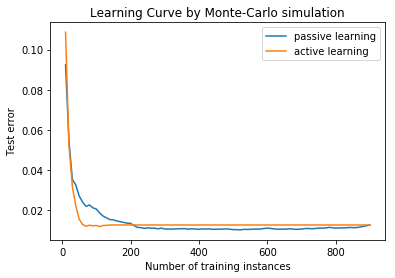

In [11]:
import matplotlib.pyplot as plt
n_range = np.arange(10, 901, 10)
plt.plot(n_range, test_err_each_svm, label = 'passive learning')
plt.plot(n_range, test_err_each_svm1, label = 'active learning')
plt.title('Learning Curve by Monte-Carlo simulation')
plt.xlabel('Number of training instances')
plt.ylabel('Test error')
plt.legend(loc='best')
plt.show()

## Conclusion: Active learning learns faster than passive learning. Because from the learning curve, we can see that the test error of active learning decreases faster than that of passive learning. 
At the beginning, the test error of both passive and active learning is large since they all learn from 10 random selected data at this time.

Passive learning only learns from random selected data. So its curve decreases slowly and is always flutuating. Random selected data cannot guarantee learning efficiency.

Active learning tends to learn from the data which is more difficult to interpret. In this problem, each time we add 10 closest data points in the training set to the hyperplane of the SVM to our training pool. So, each time SVM learn from additional 10 data points which are the most difficult to classify. Eventually, the learning becomes easier and easier, thus the test error decreases very fast and then becomes flat.